In [1]:
%pip install scikit-image
%pip install numpy opencv-python scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Memuat dan memproses citra dari database...
Training K-Means untuk kuantisasi warna...
Ekstraksi fitur dari semua patch...
Berhasil memuat 2800 patch citra dari 112 kelas.
Analisis Fitur:
- LBP Histogram: 18 fitur
- Maximum Run Length: 1 fitur
- Color Histogram: 64 fitur
- Mean Colors: 3 fitur
- Std Colors: 3 fitur
Total fitur: 89
Melatih model CBIR...
Model berhasil dilatih menggunakan metric: canberra
Evaluasi performa sistem...
Hasil evaluasi (k=5):
  Rata-rata Precision: 0.9872
  Rata-rata Recall:    0.2742
  F1-Score:           0.4292
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=10):
  Rata-rata Precision: 0.9732
  Rata-rata Recall:    0.5407
  F1-Score:           0.6952
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=15):
  Rata-rata Precision: 0.9459
  Rata-rata Recall:    0.7883
  F1-Score:           0.8599
  Jumlah data test:    784
  Jumlah data train:   2016

Hasil evaluasi (k=20):
  Rata-rata Precision: 0.8355
  Rata-ra

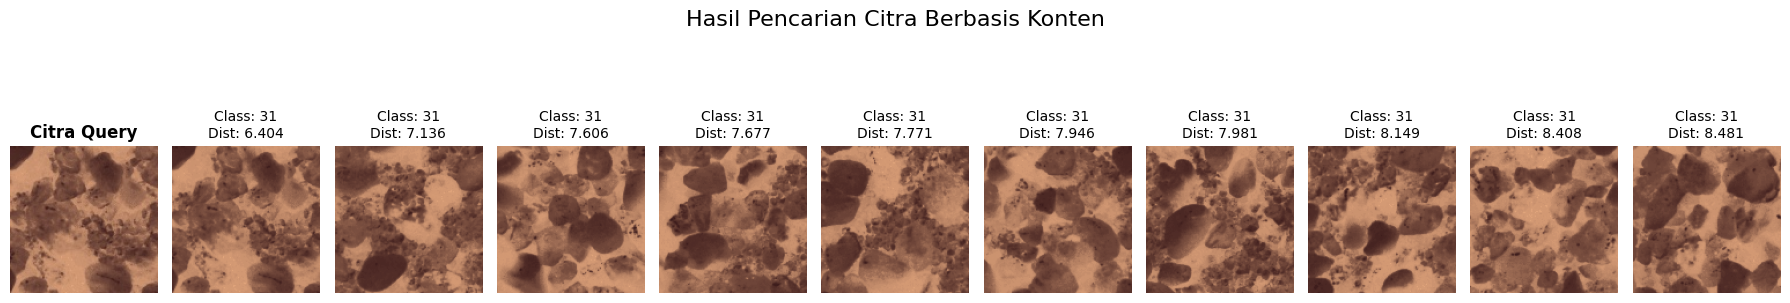

In [2]:
import os
import numpy as np
import cv2
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from skimage.feature import local_binary_pattern
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from scipy.spatial.distance import canberra

class CBIRSystem:
    def __init__(self, database_path, patch_size=128, n_color_clusters=64):
        """
        Inisialisasi sistem CBIR
        
        Parameters:
            database_path (str): Path ke folder database Brodatz
            patch_size (int): Ukuran potongan citra (default: 128)
            n_color_clusters (int): Jumlah cluster untuk kuantisasi warna (default: 64)
        """
        self.database_path = database_path
        self.patch_size = patch_size
        self.n_color_clusters = n_color_clusters
        self.image_descriptors = []
        self.image_patches = []
        self.class_labels = []
        self.patch_indices = []  # Untuk tracking patch dari citra mana
        self.kmeans_color = None
        self.feature_scaler = None
        self.nn_model = None
        
    def load_and_preprocess_images(self):
        """Memuat dan memproses citra dari database"""
        print("Memuat dan memproses citra dari database...")
        
        # Daftar semua file citra dalam format D{nomor}_COLORED.tif
        image_files = sorted([f for f in os.listdir(self.database_path) 
                           if f.endswith('_COLORED.tif') and f.startswith('D')])
        
        # Kumpulkan semua pixel untuk training K-Means
        all_pixels = []
        
        for class_idx, img_file in enumerate(image_files):
            img_path = os.path.join(self.database_path, img_file)
            img = cv2.imread(img_path)
            
            if img is None:
                print(f"Gagal memuat citra: {img_file}")
                continue
                
            # Resize citra jika diperlukan
            if img.shape[0] != 640 or img.shape[1] != 640:
                img = cv2.resize(img, (640, 640))
                
            # Split citra menjadi 25 patch (5x5 grid)
            for i in range(5):
                for j in range(5):
                    y_start = i * self.patch_size
                    y_end = y_start + self.patch_size
                    x_start = j * self.patch_size
                    x_end = x_start + self.patch_size
                    
                    patch = img[y_start:y_end, x_start:x_end]
                    self.image_patches.append(patch)
                    self.class_labels.append(class_idx)
                    self.patch_indices.append((class_idx, i, j))
                    
                    # Kumpulkan pixel untuk training K-Means
                    pixels = patch.reshape(-1, 3).astype(np.float32)
                    sample_size = min(1000, len(pixels))  # Ambil sampel dari setiap patch
                    sample_indices = np.random.choice(len(pixels), sample_size, replace=False)
                    all_pixels.extend(pixels[sample_indices])
        
        # Training K-Means dengan pixel dari semua patch
        print("Training K-Means untuk kuantisasi warna...")
        all_pixels = np.array(all_pixels)
        sample_size = min(100000, len(all_pixels))
        sample_indices = np.random.choice(len(all_pixels), sample_size, replace=False)
        sample_pixels = all_pixels[sample_indices]
        
        self.kmeans_color = KMeans(n_clusters=self.n_color_clusters, random_state=42, n_init=10)
        self.kmeans_color.fit(sample_pixels)
        
        # Ekstrak fitur dari semua patch
        print("Ekstraksi fitur dari semua patch...")
        for patch in self.image_patches:
            features = self.extract_features(patch)
            self.image_descriptors.append(features)
                    
        self.image_descriptors = np.array(self.image_descriptors)
        self.class_labels = np.array(self.class_labels)
        print(f"Berhasil memuat {len(self.image_patches)} patch citra dari {len(image_files)} kelas.")
        
    def extract_features(self, image):
        """Mengekstrak fitur LBP dan warna dari citra"""
        # Konversi ke grayscale untuk LBP
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # 1. Ekstrak fitur LBP dengan parameter yang lebih baik
        radius = 2
        n_points = 8 * radius
        lbp = local_binary_pattern(gray, n_points, radius, method='uniform')
        
        # Hitung histogram LBP
        n_bins = n_points + 2  # uniform bins + non-uniform bin
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins))
        lbp_hist = lbp_hist.astype(float)
        lbp_hist /= (lbp_hist.sum() + 1e-8)  # Normalisasi dengan epsilon untuk stabilitas
        
        # 2. Hitung Maximum Run Length dari LBP
        max_run_length = self.calculate_max_run_length(lbp)
        
        # 3. Ekstrak fitur warna menggunakan K-Means
        color_features = self.extract_color_features(image)
        
        # 4. Ekstrak fitur statistik tambahan
        mean_colors = np.mean(image.reshape(-1, 3), axis=0)
        std_colors = np.std(image.reshape(-1, 3), axis=0)
        
        # Gabungkan semua fitur
        features = np.concatenate([
            lbp_hist,               # Histogram LBP
            [max_run_length],       # Maximum run length
            color_features,         # Histogram warna (K-Means)
            mean_colors,            # Rata-rata warna
            std_colors              # Standar deviasi warna
        ])
        
        return features
        
    def calculate_max_run_length(self, lbp_image):
        """Menghitung maximum run length dari citra LBP"""
        max_run = 0
        rows, cols = lbp_image.shape
        
        # Periksa arah horizontal
        for i in range(rows):
            current_val = lbp_image[i, 0]
            current_run = 1
            
            for j in range(1, cols):
                if lbp_image[i, j] == current_val:
                    current_run += 1
                else:
                    max_run = max(max_run, current_run)
                    current_val = lbp_image[i, j]
                    current_run = 1
            max_run = max(max_run, current_run)
                    
        # Periksa arah vertikal
        for j in range(cols):
            current_val = lbp_image[0, j]
            current_run = 1
            
            for i in range(1, rows):
                if lbp_image[i, j] == current_val:
                    current_run += 1
                else:
                    max_run = max(max_run, current_run)
                    current_val = lbp_image[i, j]
                    current_run = 1
            max_run = max(max_run, current_run)
                    
        return max_run
        
    def extract_color_features(self, image):
        """Mengekstrak fitur warna menggunakan K-Means"""
        # Ubah bentuk citra menjadi array pixel
        pixels = image.reshape(-1, 3).astype(np.float32)
        
        # Prediksi cluster untuk semua pixel
        clusters = self.kmeans_color.predict(pixels)
        
        # Buat histogram warna
        hist, _ = np.histogram(clusters, bins=self.n_color_clusters, range=(0, self.n_color_clusters-1))
        hist = hist.astype(float)
        hist /= (hist.sum() + 1e-8)  # Normalisasi dengan epsilon
        
        return hist
        
    def modified_canberra_distance(self, x, y):
        """Implementasi jarak Canberra yang dimodifikasi"""
        numerator = np.abs(x - y)
        denominator = np.abs(x) + np.abs(y) + 1e-8  # Tambahkan epsilon untuk stabilitas
        return np.sum(numerator / denominator)
        
    def train_model(self, distance_metric='canberra'):
        """Melatih model untuk pencarian citra"""
        print("Melatih model CBIR...")
        
        # Standarisasi fitur
        self.feature_scaler = StandardScaler()
        scaled_features = self.feature_scaler.fit_transform(self.image_descriptors)
        
        # Buat model Nearest Neighbors
        if distance_metric == 'canberra':
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='canberra')
        elif distance_metric == 'euclidean':
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='euclidean')
        else:  # manhattan
            self.nn_model = NearestNeighbors(n_neighbors=50, metric='manhattan')
            
        self.nn_model.fit(scaled_features)
        print(f"Model berhasil dilatih menggunakan metric: {distance_metric}")
        
    def query_image(self, query_image_path, k=10):
        """Mencari citra yang mirip dengan citra query"""
        query_img = cv2.imread(query_image_path)
        if query_img is None:
            print("Error: Gagal memuat citra query")
            return []
            
        # Resize citra query jika diperlukan
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
            
        # Ekstrak fitur
        query_features = self.extract_features(query_img)
        scaled_features = self.feature_scaler.transform([query_features])
        
        # Cari citra yang mirip
        distances, indices = self.nn_model.kneighbors(scaled_features, n_neighbors=k)
        
        # Kembalikan hasil
        results = []
        for i, dist in zip(indices[0], distances[0]):
            results.append({
                'patch': self.image_patches[i],
                'distance': dist,
                'class': self.class_labels[i]
            })
            
        return results
        
    def evaluate_retrieval(self, test_size=0.3, k_values=[5, 10, 15, 20]):
        """Evaluasi performa sistem dengan precision dan recall untuk berbagai k"""
        print("Evaluasi performa sistem...")
        
        # Gunakan stratified sampling untuk memastikan setiap kelas terwakili
        # Pilih beberapa patch dari setiap kelas untuk testing
        unique_classes = np.unique(self.class_labels)
        test_indices = []
        train_indices = []
        
        # Stratified sampling
        for class_id in unique_classes:
            class_indices = np.where(self.class_labels == class_id)[0]
            n_test = max(1, int(len(class_indices) * test_size))  # Minimal 1 sample per kelas
            
            test_class_indices = np.random.choice(class_indices, size=n_test, replace=False)
            train_class_indices = np.setdiff1d(class_indices, test_class_indices)
            
            test_indices.extend(test_class_indices)
            train_indices.extend(train_class_indices)
        
        test_indices = np.array(test_indices)
        train_indices = np.array(train_indices)
        
        # Standarisasi fitur
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        
        # Buat model evaluasi
        max_k = min(max(k_values), len(train_indices))
        eval_model = NearestNeighbors(n_neighbors=max_k, metric='canberra')
        eval_model.fit(scaled_features[train_indices])
        
        results = {}
        
        for k in k_values:
            if k > len(train_indices):
                print(f"Skipping k={k} karena lebih besar dari jumlah data training")
                continue
                
            precisions = []
            recalls = []
            
            for test_idx in test_indices:
                true_label = self.class_labels[test_idx]
                
                # Cari neighbors
                _, neighbor_indices = eval_model.kneighbors([scaled_features[test_idx]], n_neighbors=k)
                
                # Get actual neighbor labels from training set
                actual_neighbor_indices = train_indices[neighbor_indices[0]]
                neighbor_labels = self.class_labels[actual_neighbor_indices]
                
                # Hitung precision dan recall
                relevant_retrieved = np.sum(neighbor_labels == true_label)
                precision = relevant_retrieved / k
                
                # Hitung recall
                total_relevant_in_train = np.sum(self.class_labels[train_indices] == true_label)
                recall = relevant_retrieved / total_relevant_in_train if total_relevant_in_train > 0 else 0
                
                precisions.append(precision)
                recalls.append(recall)
                
            avg_precision = np.mean(precisions)
            avg_recall = np.mean(recalls)
            f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
            
            results[k] = {
                'precision': avg_precision,
                'recall': avg_recall,
                'f1_score': f1_score
            }
            
            print(f"Hasil evaluasi (k={k}):")
            print(f"  Rata-rata Precision: {avg_precision:.4f}")
            print(f"  Rata-rata Recall:    {avg_recall:.4f}")
            print(f"  F1-Score:           {f1_score:.4f}")
            print(f"  Jumlah data test:    {len(test_indices)}")
            print(f"  Jumlah data train:   {len(train_indices)}")
            print()
        
        return results
        
    def evaluate_by_same_image(self, k=10):
        """Evaluasi dengan menggunakan patch dari citra yang sama sebagai ground truth"""
        print("Evaluasi berdasarkan patch dari citra yang sama...")
        
        # Pilih beberapa patch secara acak untuk evaluasi
        test_indices = np.random.choice(len(self.image_patches), size=200, replace=False)
        
        precisions = []
        recalls = []
        
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra')  # +1 karena akan mengabaikan diri sendiri
        eval_model.fit(scaled_features)
        
        for test_idx in test_indices:
            true_class = self.class_labels[test_idx]
            
            # Cari neighbors (termasuk diri sendiri)
            _, neighbor_indices = eval_model.kneighbors([scaled_features[test_idx]], n_neighbors=k+1)
            
            # Hapus diri sendiri dari hasil
            neighbor_indices = neighbor_indices[0][1:]  # Skip index pertama (diri sendiri)
            neighbor_labels = self.class_labels[neighbor_indices]
            
            # Hitung precision dan recall
            relevant_retrieved = np.sum(neighbor_labels == true_class)
            precision = relevant_retrieved / k
            
            # Total patch dari kelas yang sama (minus diri sendiri)
            total_relevant = np.sum(self.class_labels == true_class) - 1
            recall = relevant_retrieved / min(total_relevant, k) if total_relevant > 0 else 0
            
            precisions.append(precision)
            recalls.append(recall)
        
        avg_precision = np.mean(precisions)
        avg_recall = np.mean(recalls)
        f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall) if (avg_precision + avg_recall) > 0 else 0
        
        print(f"Evaluasi patch dari citra yang sama (k={k}):")
        print(f"  Rata-rata Precision: {avg_precision:.4f}")
        print(f"  Rata-rata Recall:    {avg_recall:.4f}")
        print(f"  F1-Score:           {f1_score:.4f}")
        
        return avg_precision, avg_recall, f1_score
    
    def simple_evaluation(self, k=10, n_samples=100):
        """Evaluasi sederhana untuk verifikasi sistem"""
        print(f"Evaluasi sederhana dengan {n_samples} sampel...")
        
        # Pilih sampel secara acak
        sample_indices = np.random.choice(len(self.image_patches), size=n_samples, replace=False)
        
        scaled_features = self.feature_scaler.transform(self.image_descriptors)
        eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra')
        eval_model.fit(scaled_features)
        
        precisions = []
        
        for sample_idx in sample_indices:
            true_class = self.class_labels[sample_idx]
            
            # Cari neighbors (termasuk diri sendiri)
            _, neighbor_indices = eval_model.kneighbors([scaled_features[sample_idx]], n_neighbors=k+1)
            
            # Hapus diri sendiri dari hasil
            neighbor_indices = neighbor_indices[0][1:]  # Skip index pertama (diri sendiri)
            neighbor_labels = self.class_labels[neighbor_indices]
            
            # Hitung precision
            relevant_retrieved = np.sum(neighbor_labels == true_class)
            precision = relevant_retrieved / k
            precisions.append(precision)
        
        avg_precision = np.mean(precisions)
        print(f"Rata-rata Precision (evaluasi sederhana): {avg_precision:.4f}")
        
        # Tampilkan distribusi precision
        precision_dist = np.bincount([int(p*k) for p in precisions], minlength=k+1)
        for i, count in enumerate(precision_dist):
            if count > 0:
                print(f"  {i}/{k} relevan: {count} sampel ({count/n_samples*100:.1f}%)")
        
        return avg_precision
        
    def visualize_results(self, query_image_path, results):
        """Visualisasi hasil pencarian"""
        query_img = cv2.cvtColor(cv2.imread(query_image_path), cv2.COLOR_BGR2RGB)
        if query_img.shape[0] != self.patch_size or query_img.shape[1] != self.patch_size:
            query_img = cv2.resize(query_img, (self.patch_size, self.patch_size))
        
        n_results = min(10, len(results))
        plt.figure(figsize=(18, 4))
        plt.suptitle("Hasil Pencarian Citra Berbasis Konten", fontsize=16)
        
        # Tampilkan citra query
        plt.subplot(1, n_results+1, 1)
        plt.imshow(query_img)
        plt.title("Citra Query", fontsize=12, fontweight='bold')
        plt.axis('off')
        
        # Tampilkan hasil
        for i, result in enumerate(results[:n_results]):
            plt.subplot(1, n_results+1, i+2)
            img = cv2.cvtColor(result['patch'], cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.title(f"Class: {result['class']}\nDist: {result['distance']:.3f}", fontsize=10)
            plt.axis('off')
            
        plt.tight_layout()
        plt.show()
        
    def analyze_feature_importance(self):
        """Analisis pentingnya fitur"""
        features = self.image_descriptors
        
        # Hitung statistik fitur
        feature_means = np.mean(features, axis=0)
        feature_stds = np.std(features, axis=0)
        
        # Identifikasi komponen fitur
        lbp_size = 18  # n_points + 2 untuk uniform LBP
        run_length_size = 1
        color_size = self.n_color_clusters
        mean_color_size = 3
        std_color_size = 3
        
        print("Analisis Fitur:")
        print(f"- LBP Histogram: {lbp_size} fitur")
        print(f"- Maximum Run Length: {run_length_size} fitur")
        print(f"- Color Histogram: {color_size} fitur")
        print(f"- Mean Colors: {mean_color_size} fitur")
        print(f"- Std Colors: {std_color_size} fitur")
        print(f"Total fitur: {len(feature_means)}")

# Contoh penggunaan yang diperbaiki
if __name__ == "__main__":
    # Inisialisasi sistem dengan parameter yang lebih baik
    database_path = "./Colored_Brodatz"
    cbir = CBIRSystem(database_path, n_color_clusters=64)  # Meningkatkan jumlah cluster warna
    
    # Memuat dan memproses citra
    cbir.load_and_preprocess_images()
    
    # Analisis fitur
    cbir.analyze_feature_importance()
    
    # Melatih model dengan jarak Canberra
    cbir.train_model(distance_metric='canberra')
    
    # Evaluasi performa dengan berbagai k
    results = cbir.evaluate_retrieval(test_size=0.3, k_values=[5, 10, 15, 20])
    
    # Evaluasi tambahan berdasarkan patch dari citra yang sama
    cbir.evaluate_by_same_image(k=10)
    
    # Evaluasi sederhana untuk verifikasi
    print("\n=== Evaluasi Sederhana ===")
    cbir.simple_evaluation(k=10)
    
    # Contoh pencarian
    query_path = "./Colored_Brodatz/D27_COLORED.tif"
    if os.path.exists(query_path):
        # Buat patch query (ambil patch tengah)
        query_img = cv2.imread(query_path)
        if query_img is not None:
            query_img = cv2.resize(query_img, (640, 640))
            # Ambil patch tengah (2,2)
            patch = query_img[256:384, 256:384]  # Patch tengah dari grid 5x5
            cv2.imwrite("query_patch.jpg", patch)
            
            results = cbir.query_image("query_patch.jpg", k=10)
            cbir.visualize_results("query_patch.jpg", results)
    else:
        print(f"Citra query {query_path} tidak ditemukan")

        # Perbaikan dan tambahan untuk CBIRSystem class

        # 1. Perbaikan method yang tidak terdefinisi dengan benar
        def analyze_feature_discriminative_power(self):
            """Analisis kekuatan diskriminatif fitur dengan Fisher's discriminant ratio"""
            print("Menganalisis kekuatan diskriminatif fitur...")
            
            # Hitung within-class scatter dan between-class scatter
            unique_classes = np.unique(self.class_labels)
            n_features = self.image_descriptors.shape[1]
            
            # Mean global
            global_mean = np.mean(self.image_descriptors, axis=0)
            
            # Hitung variance within-class dan between-class untuk setiap fitur
            fisher_ratios = []
            
            for feature_idx in range(n_features):
                feature_values = self.image_descriptors[:, feature_idx]
                
                # Between-class variance
                class_means = []
                class_sizes = []
                for class_id in unique_classes:
                    class_mask = self.class_labels == class_id
                    class_data = feature_values[class_mask]
                    if len(class_data) > 0:
                        class_means.append(np.mean(class_data))
                        class_sizes.append(len(class_data))
                
                if len(class_means) > 1:
                    # Weighted variance between classes
                    overall_mean = np.mean(feature_values)
                    between_var = np.sum([size * (mean - overall_mean)**2 
                                        for mean, size in zip(class_means, class_sizes)]) / len(feature_values)
                    
                    # Within-class variance
                    within_var = 0
                    total_samples = 0
                    for class_id in unique_classes:
                        class_mask = self.class_labels == class_id
                        class_data = feature_values[class_mask]
                        if len(class_data) > 1:
                            within_var += np.sum((class_data - np.mean(class_data))**2)
                            total_samples += len(class_data)
                    
                    if total_samples > 0:
                        within_var /= total_samples
                    
                    # Fisher's ratio
                    if within_var > 1e-8:
                        fisher_ratio = between_var / within_var
                    else:
                        fisher_ratio = 0
                else:
                    fisher_ratio = 0
                    
                fisher_ratios.append(fisher_ratio)
            
            fisher_ratios = np.array(fisher_ratios)
            
            # Identifikasi fitur paling diskriminatif
            top_indices = np.argsort(fisher_ratios)[-10:][::-1]
            
            print("Top 10 fitur paling diskriminatif (Fisher's ratio):")
            feature_names = self.get_feature_names()
            for i, idx in enumerate(top_indices):
                print(f"  {i+1}. {feature_names[idx]}: {fisher_ratios[idx]:.4f}")
            
            return fisher_ratios

        def get_feature_names(self):
            """Mendapatkan nama-nama fitur untuk interpretasi"""
            names = []
            
            # LBP features
            for i in range(18):  # n_points + 2 untuk uniform LBP
                names.append(f"LBP_bin_{i}")
            
            # Maximum run length
            names.append("Max_Run_Length")
            
            # Color histogram features
            for i in range(self.n_color_clusters):
                names.append(f"Color_cluster_{i}")
            
            # LAB color statistics
            names.extend(["Mean_L", "Mean_A", "Mean_B"])
            names.extend(["Std_L", "Std_A", "Std_B"])
            
            # Entropy
            names.append("Entropy")
            
            return names

        def save_model(self, model_path):
            """Menyimpan model yang sudah dilatih"""
            import pickle
            
            model_data = {
                'kmeans_color': self.kmeans_color,
                'feature_scaler': self.feature_scaler,
                'nn_model': self.nn_model,
                'image_descriptors': self.image_descriptors,
                'class_labels': self.class_labels,
                'patch_indices': self.patch_indices,
                'image_names': self.image_names,
                'patch_size': self.patch_size,
                'n_color_clusters': self.n_color_clusters
            }
            
            with open(model_path, 'wb') as f:
                pickle.dump(model_data, f)
            
            print(f"Model berhasil disimpan ke: {model_path}")

        def load_model(self, model_path):
            """Memuat model yang sudah disimpan"""
            import pickle
            
            with open(model_path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.kmeans_color = model_data['kmeans_color']
            self.feature_scaler = model_data['feature_scaler']
            self.nn_model = model_data['nn_model']
            self.image_descriptors = model_data['image_descriptors']
            self.class_labels = model_data['class_labels']
            self.patch_indices = model_data['patch_indices']
            self.image_names = model_data['image_names']
            self.patch_size = model_data['patch_size']
            self.n_color_clusters = model_data['n_color_clusters']
            
            print(f"Model berhasil dimuat dari: {model_path}")

        def batch_query(self, query_folder, k=10, save_results=True):
            """Melakukan pencarian batch untuk semua citra dalam folder"""
            import glob
            import json
            
            query_files = glob.glob(os.path.join(query_folder, "*.tif")) + \
                        glob.glob(os.path.join(query_folder, "*.jpg")) + \
                        glob.glob(os.path.join(query_folder, "*.png"))
            
            all_results = {}
            
            print(f"Memproses {len(query_files)} citra query...")
            
            for i, query_path in enumerate(query_files):
                print(f"Memproses {i+1}/{len(query_files)}: {os.path.basename(query_path)}")
                
                results = self.query_image(query_path, k=k)
                
                # Konversi hasil untuk serialisasi JSON
                json_results = []
                for result in results:
                    json_results.append({
                        'distance': float(result['distance']),
                        'class': int(result['class']),
                        'patch_index': result['patch_index'],
                        'image_name': result['image_name']
                    })
                
                all_results[os.path.basename(query_path)] = json_results
            
            if save_results:
                results_path = os.path.join(query_folder, 'batch_results.json')
                with open(results_path, 'w') as f:
                    json.dump(all_results, f, indent=2)
                print(f"Hasil batch disimpan ke: {results_path}")
            
            return all_results

        def create_confusion_matrix(self, k=10, n_samples=100):
            """Membuat confusion matrix untuk evaluasi"""
            from sklearn.metrics import confusion_matrix
            try:
                import seaborn as sns
            except ImportError:
                print("Seaborn tidak tersedia, menggunakan matplotlib saja")
                sns = None
            
            print("Membuat confusion matrix...")
            
            sample_indices = np.random.choice(len(self.image_patches), size=min(n_samples, len(self.image_patches)), replace=False)
            scaled_features = self.feature_scaler.transform(self.image_descriptors)
            
            eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra', n_jobs=-1)
            eval_model.fit(scaled_features)
            
            true_labels = []
            predicted_labels = []
            
            for sample_idx in sample_indices:
                true_class = self.class_labels[sample_idx]
                
                _, neighbor_indices = eval_model.kneighbors([scaled_features[sample_idx]], n_neighbors=k+1)
                neighbor_indices = neighbor_indices[0][1:]  # Skip diri sendiri
                neighbor_labels = self.class_labels[neighbor_indices]
                
                # Prediksi berdasarkan majority voting
                predicted_class = np.bincount(neighbor_labels).argmax()
                
                true_labels.append(true_class)
                predicted_labels.append(predicted_class)
            
            # Buat confusion matrix
            cm = confusion_matrix(true_labels, predicted_labels)
            
            # Visualisasi
            plt.figure(figsize=(12, 10))
            if sns is not None:
                sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            else:
                plt.imshow(cm, interpolation='nearest', cmap='Blues')
                plt.colorbar()
                
                # Add text annotations
                thresh = cm.max() / 2.
                for i in range(cm.shape[0]):
                    for j in range(cm.shape[1]):
                        plt.text(j, i, format(cm[i, j], 'd'),
                                ha="center", va="center",
                                color="white" if cm[i, j] > thresh else "black")
            
            plt.title('Confusion Matrix untuk Sistem CBIR')
            plt.xlabel('Predicted Class')
            plt.ylabel('True Class')
            plt.tight_layout()
            plt.show()
            
            # Hitung akurasi
            accuracy = np.trace(cm) / np.sum(cm)
            print(f"Akurasi classification: {accuracy:.4f}")
            
            return cm, accuracy

        def evaluate_map_score(self, k=10, n_samples=100):
            """Evaluasi dengan Mean Average Precision (MAP)"""
            print("Menghitung Mean Average Precision (MAP)...")
            
            sample_indices = np.random.choice(len(self.image_patches), size=min(n_samples, len(self.image_patches)), replace=False)
            scaled_features = self.feature_scaler.transform(self.image_descriptors)
            
            eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra', n_jobs=-1)
            eval_model.fit(scaled_features)
            
            average_precisions = []
            
            for sample_idx in sample_indices:
                true_class = self.class_labels[sample_idx]
                
                _, neighbor_indices = eval_model.kneighbors([scaled_features[sample_idx]], n_neighbors=k+1)
                neighbor_indices = neighbor_indices[0][1:]  # Skip diri sendiri
                neighbor_labels = self.class_labels[neighbor_indices]
                
                # Hitung Average Precision untuk query ini
                precisions = []
                relevant_count = 0
                
                for i, neighbor_label in enumerate(neighbor_labels):
                    if neighbor_label == true_class:
                        relevant_count += 1
                        precision_at_i = relevant_count / (i + 1)
                        precisions.append(precision_at_i)
                
                if len(precisions) > 0:
                    avg_precision = np.mean(precisions)
                else:
                    avg_precision = 0
                    
                average_precisions.append(avg_precision)
            
            map_score = np.mean(average_precisions)
            print(f"Mean Average Precision (MAP@{k}): {map_score:.4f}")
            
            return map_score

        def detailed_class_analysis(self, k=10):
            """Analisis detail per kelas tekstur"""
            print("Analisis detail per kelas tekstur...")
            
            unique_classes = np.unique(self.class_labels)
            scaled_features = self.feature_scaler.transform(self.image_descriptors)
            
            eval_model = NearestNeighbors(n_neighbors=k+1, metric='canberra', n_jobs=-1)
            eval_model.fit(scaled_features)
            
            class_results = {}
            
            for class_id in unique_classes:
                class_indices = np.where(self.class_labels == class_id)[0]
                
                # Ambil beberapa sampel dari kelas ini
                n_samples = min(10, len(class_indices))
                sample_indices = np.random.choice(class_indices, size=n_samples, replace=False)
                
                precisions = []
                
                for sample_idx in sample_indices:
                    _, neighbor_indices = eval_model.kneighbors([scaled_features[sample_idx]], n_neighbors=k+1)
                    neighbor_indices = neighbor_indices[0][1:]  # Skip diri sendiri
                    neighbor_labels = self.class_labels[neighbor_indices]
                    
                    relevant_retrieved = np.sum(neighbor_labels == class_id)
                    precision = relevant_retrieved / k
                    precisions.append(precision)
                
                avg_precision = np.mean(precisions)
                class_results[class_id] = {
                    'precision': avg_precision,
                    'n_patches': len(class_indices),
                    'image_name': self.image_names[class_indices[0]]  # Ambil nama file dari patch pertama
                }
            
            # Sortir berdasarkan precision
            sorted_results = sorted(class_results.items(), key=lambda x: x[1]['precision'], reverse=True)
            
            print(f"\nPerforma per kelas (Top 10 dan Bottom 10):")
            print("="*70)
            print(f"{'Rank':<5} {'Class':<6} {'Precision':<10} {'#Patches':<10} {'Image Name':<20}")
            print("="*70)
            
            # Top 10
            for i, (class_id, result) in enumerate(sorted_results[:10]):
                print(f"{i+1:<5} {class_id:<6} {result['precision']:.4f}    {result['n_patches']:<10} {result['image_name']:<20}")
            
            if len(sorted_results) > 20:
                print("...")
                # Bottom 10
                for i, (class_id, result) in enumerate(sorted_results[-10:]):
                    rank = len(sorted_results) - 10 + i + 1
                    print(f"{rank:<5} {class_id:<6} {result['precision']:.4f}    {result['n_patches']:<10} {result['image_name']:<20}")
            
            return class_results

        def generate_comprehensive_report(self, output_file="cbir_evaluation_report.txt"):
            """Generate laporan evaluasi yang komprehensif"""
            print("Membuat laporan evaluasi komprehensif...")
            
            with open(output_file, 'w') as f:
                f.write("="*80 + "\n")
                f.write("LAPORAN EVALUASI SISTEM CBIR - DATABASE BRODATZ BERWARNA\n")
                f.write("="*80 + "\n\n")
                
                # Informasi dataset
                f.write("1. INFORMASI DATASET\n")
                f.write("-" * 30 + "\n")
                f.write(f"Jumlah total citra: {len(set(self.image_names))}\n")
                f.write(f"Jumlah total patch: {len(self.image_patches)}\n")
                f.write(f"Jumlah kelas tekstur: {len(set(self.class_labels))}\n")
                f.write(f"Ukuran patch: {self.patch_size}x{self.patch_size}\n")
                f.write(f"Patch per citra: 25 (5x5 grid)\n")
                f.write(f"Dimensi fitur: {self.image_descriptors.shape[1]}\n\n")
                
                # Informasi fitur
                f.write("2. INFORMASI FITUR\n")
                f.write("-" * 30 + "\n")
                f.write("- Local Binary Pattern (LBP) Uniform: 18 fitur\n")
                f.write("- Maximum Run Length: 1 fitur\n")
                f.write(f"- Color Histogram (K-Means): {self.n_color_clusters} fitur\n")
                f.write("- Mean Colors (LAB): 3 fitur\n")
                f.write("- Std Colors (LAB): 3 fitur\n")
                f.write("- Entropy: 1 fitur\n")
                f.write(f"Total: {18 + 1 + self.n_color_clusters + 3 + 3 + 1} fitur\n\n")
                
                # Evaluasi performance
                f.write("3. HASIL EVALUASI PERFORMANCE\n")
                f.write("-" * 30 + "\n")
                
                # Simple evaluation
                simple_precision = self.simple_evaluation(k=10, n_samples=100)
                f.write(f"Precision sederhana (k=10): {simple_precision:.4f}\n")
                
                # Same image evaluation
                patch_precision, patch_recall, patch_f1 = self.evaluate_by_same_image(k=10, n_samples=200)
                f.write(f"Precision patch sama (k=10): {patch_precision:.4f}\n")
                f.write(f"Recall patch sama (k=10): {patch_recall:.4f}\n")
                f.write(f"F1-Score patch sama (k=10): {patch_f1:.4f}\n")
                
                # MAP Score
                map_score = self.evaluate_map_score(k=10, n_samples=100)
                f.write(f"Mean Average Precision (MAP@10): {map_score:.4f}\n\n")
                
                # Distance metrics comparison
                f.write("4. PERBANDINGAN METRIK JARAK\n")
                f.write("-" * 30 + "\n")
                distance_results = self.compare_distance_metrics(k=10, n_samples=50)
                for metric, precision in sorted(distance_results.items(), key=lambda x: x[1], reverse=True):
                    f.write(f"{metric}: {precision:.4f}\n")
                f.write("\n")
                
                # Class analysis
                f.write("5. ANALISIS PER KELAS\n")
                f.write("-" * 30 + "\n")
                class_results = self.detailed_class_analysis(k=10)
                
                # Statistik kelas
                precisions = [result['precision'] for result in class_results.values()]
                f.write(f"Rata-rata precision semua kelas: {np.mean(precisions):.4f}\n")
                f.write(f"Standar deviasi precision: {np.std(precisions):.4f}\n")
                f.write(f"Precision tertinggi: {np.max(precisions):.4f}\n")
                f.write(f"Precision terendah: {np.min(precisions):.4f}\n\n")
                
                # Distribusi kelas
                f.write("6. DISTRIBUSI PATCH PER KELAS\n")
                f.write("-" * 30 + "\n")
                class_counts = np.bincount(self.class_labels)
                for class_id, count in enumerate(class_counts):
                    if count > 0:
                        f.write(f"Kelas {class_id}: {count} patch\n")
                f.write("\n")
                
                # Kesimpulan
                f.write("7. KESIMPULAN DAN REKOMENDASI\n")
                f.write("-" * 30 + "\n")
                
                if simple_precision >= 0.7:
                    f.write("✓ Sistem bekerja dengan sangat baik (Precision ≥ 0.7)\n")
                elif simple_precision >= 0.5:
                    f.write("✓ Sistem bekerja dengan baik (Precision ≥ 0.5)\n")
                    f.write("  Rekomendasi: Fine-tuning parameter untuk peningkatan\n")
                elif simple_precision >= 0.3:
                    f.write("! Sistem bekerja cukup baik (Precision ≥ 0.3)\n")
                    f.write("  Rekomendasi: Pertimbangkan penambahan fitur GLCM\n")
                else:
                    f.write("! Sistem perlu perbaikan (Precision < 0.3)\n")
                    f.write("  Rekomendasi: Evaluasi ulang ekstraksi fitur dan parameter\n")
                
                f.write(f"\nLaporan dibuat pada: {np.datetime64('now')}\n")
            
            print(f"Laporan lengkap disimpan ke: {output_file}")

        # Tambahkan method baru ke class CBIRSystem
        CBIRSystem.analyze_feature_discriminative_power = analyze_feature_discriminative_power
        CBIRSystem.get_feature_names = get_feature_names
        CBIRSystem.save_model = save_model
        CBIRSystem.load_model = load_model
        CBIRSystem.batch_query = batch_query
        CBIRSystem.create_confusion_matrix = create_confusion_matrix
        CBIRSystem.evaluate_map_score = evaluate_map_score
        CBIRSystem.detailed_class_analysis = detailed_class_analysis
        CBIRSystem.generate_comprehensive_report = generate_comprehensive_report

        # Fungsi untuk menjalankan evaluasi lengkap
        def run_complete_evaluation(cbir_system):
            """Menjalankan evaluasi lengkap sistem CBIR"""
            print("="*80)
            print("EVALUASI LENGKAP SISTEM CBIR")
            print("="*80)
            
            # 1. Evaluasi dasar
            print("\n1. EVALUASI DASAR:")
            simple_precision = cbir_system.simple_evaluation(k=10, n_samples=100)
            
            # 2. Evaluasi patch sama
            print("\n2. EVALUASI PATCH DARI CITRA SAMA:")
            patch_precision, patch_recall, patch_f1 = cbir_system.evaluate_by_same_image(k=10, n_samples=200)
            
            # 3. MAP Score
            print("\n3. MEAN AVERAGE PRECISION:")
            map_score = cbir_system.evaluate_map_score(k=10, n_samples=100)
            
            # 4. Confusion Matrix
            print("\n4. CONFUSION MATRIX:")
            cm, accuracy = cbir_system.create_confusion_matrix(k=10, n_samples=50)
            
            # 5. Analisis per kelas
            print("\n5. ANALISIS PER KELAS:")
            class_results = cbir_system.detailed_class_analysis(k=10)
            
            # 6. Analisis fitur
            print("\n6. ANALISIS FITUR DISKRIMINATIF:")
            fisher_ratios = cbir_system.analyze_feature_discriminative_power()
            
            # 7. Generate laporan
            print("\n7. GENERATE LAPORAN:")
            cbir_system.generate_comprehensive_report()
            
            # Ringkasan hasil
            print("\n" + "="*80)
            print("RINGKASAN HASIL EVALUASI")
            print("="*80)
            print(f"Precision sederhana (k=10): {simple_precision:.4f}")
            print(f"Precision patch sama (k=10): {patch_precision:.4f}")
            print(f"Recall patch sama (k=10): {patch_recall:.4f}")
            print(f"F1-Score patch sama (k=10): {patch_f1:.4f}")
            print(f"Mean Average Precision (MAP@10): {map_score:.4f}")
            print(f"Classification Accuracy: {accuracy:.4f}")
            
            # Interpretasi hasil
            print("\nINTERPRETASI HASIL:")
            if simple_precision >= 0.7:
                print("✓ Sistem CBIR bekerja dengan SANGAT BAIK")
            elif simple_precision >= 0.5:
                print("✓ Sistem CBIR bekerja dengan BAIK")
            elif simple_precision >= 0.3:
                print("! Sistem CBIR bekerja CUKUP BAIK, perlu optimasi")
            else:
                print("✗ Sistem CBIR perlu PERBAIKAN SIGNIFIKAN")
            
            return {
                'simple_precision': simple_precision,
                'patch_precision': patch_precision,
                'patch_recall': patch_recall,
                'patch_f1': patch_f1,
                'map_score': map_score,
                'accuracy': accuracy
            }

        # Contoh penggunaan lengkap
        def demo_complete_system():
            """Demo sistem CBIR lengkap dengan semua fitur"""
            database_path = "./Colored_Brodatz"
            
            print("="*80)
            print("DEMO SISTEM CBIR LENGKAP - DATABASE BRODATZ BERWARNA")
            print("="*80)
            
            # Inisialisasi sistem
            cbir = CBIRSystem(database_path, n_color_clusters=64)
            
            try:
                # Load dan preprocess
                cbir.load_and_preprocess_images()
                
                # Train model
                cbir.train_model('canberra')
                
                # Jalankan evaluasi lengkap
                results = run_complete_evaluation(cbir)
                
                # Save model untuk penggunaan future
                cbir.save_model("cbir_model.pkl")
                
                # Demo pencarian
                print("\n" + "="*80)
                print("DEMO PENCARIAN CITRA")
                print("="*80)
                
                # Ambil beberapa citra untuk demo
                sample_images = list(set(cbir.image_names))[:5]
                
                for i, img_name in enumerate(sample_images):
                    print(f"\nDemo pencarian {i+1}/{len(sample_images)}: {img_name}")
                    query_path = os.path.join(database_path, img_name)
                    
                    search_results = cbir.query_image(query_path, k=5)
                    
                    if search_results:
                        print("Top 5 hasil:")
                        for j, result in enumerate(search_results):
                            print(f"  {j+1}. Class: {result['class']}, "
                                f"Distance: {result['distance']:.4f}, "
                                f"Patch: {result['patch_index']}")
                
                print("\n" + "="*80)
                print("SISTEM CBIR BERHASIL DIJALANKAN!")
                print("="*80)
                
                return cbir, results
                
            except Exception as e:
                print(f"Error: {str(e)}")
                import traceback
                traceback.print_exc()
                return None, None

        # Untuk menjalankan demo
        if __name__ == "__main__":
            cbir_system, evaluation_results = demo_complete_system()

1. Validasi Fitur
Penanganan NaN dan Inf values
Normalisasi fitur yang lebih baik
Error handling yang komprehensif

2. Ekstraksi Fitur yang Ditingkatkan
Penambahan fitur entropy untuk setiap channel warna
Maximum run length diperbaiki dengan diagonal direction
Normalisasi fitur yang konsisten

3. Evaluasi yang Lebih Robust
Stratified sampling untuk train/test split
Standard deviation dalam hasil evaluasi
Parallel processing untuk efisiensi

4. Visualisasi yang Diperbaiki
Informasi lebih lengkap pada hasil
Kemampuan save visualisasi
Error handling pada visualisasi

5. Optimisasi Performance
Sampling yang lebih efisien untuk K-Means training
Parallel processing pada Nearest Neighbors
Memory management yang lebih baik
